In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

In [2]:
from tensorflow.keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

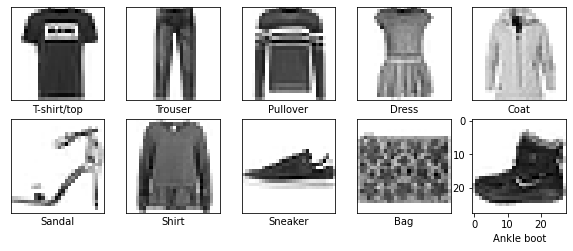

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

_, indicesList = np.unique(y_train, return_index=True)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5,5,i+1)
#     plt.grid(False)
    plt.imshow(x_train[indicesList[i]] , cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

### Activation functions

In [4]:
def sigmoid(x):
    x = np.clip(x, a_min = -700, a_max = 700)
    return (1/(1+ np.exp(-x)))

def sigmoid_grad(x,grad):
    a = sigmoid(x)
    return np.multiply(a*(1-a),grad)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x,grad):
    a = tanh(x)
    return np.multiply(1 - a*a,grad)

def relu(x):
    x[x<0] = 0
    return x

def relu_grad(x,grad):
    x[x<=0] = 0
    x[x>0] = 1
    return np.multiply(x,grad)

def linear(x):
    return x

def linear_grad(x,grad):
    return np.multiply(np.ones(x.shape),grad)


In [5]:
activations = {
    "sigmoid": [sigmoid,sigmoid_grad],
    "tanh": [tanh,tanh_grad],
    "relu": [relu,relu_grad],
    "linear": [linear,linear_grad],
}

### Loss functions

In [6]:
def cross_entropy_loss(real,pred):
    ret = np.multiply(real,pred)
    loss = -np.mean(np.log(np.sum(ret,axis=1)+1e-8))
    return loss

def cross_entropy_loss_grad(real,pred):
    ret = pred-real
    return ret

def mse_loss(real,pred):
    ret = np.mean((pred-real)**2)/2
    return ret
    
def mse_loss_grad(real,pred):
    temp = pred-real
    return (temp - (temp * pred).sum(axis=1,keepdims=True)) * pred

In [7]:
losses = {
    "cross_entropy":(cross_entropy_loss,cross_entropy_loss_grad),
    "mse": (mse_loss,mse_loss_grad)
}

### Weight Initializers

In [8]:
class initializer:
    
    def normal(inputs,outputs):
        weights = np.random.randn(inputs,outputs)
        bias = np.random.randn(outputs,)
        return weights,bias
    
    def xavier(inputs,outputs):
        scale = 1/max(1.,(inputs+outputs)/2.)
        limit = math.sqrt(3.0*scale)
        weights = np.random.uniform(-limit,limit,size=(inputs,outputs))
        bias = np.random.uniform(-limit,limit,size=(outputs,))
        return weights,bias
    

In [9]:
weight_inits = {
    "random": initializer.normal,
    "xavier": initializer.xavier
}

### Layers in the model

In [10]:
class layer:
    
    def __init__(self,neurons,inputs,activation = "sigmoid",weight_init="random"):
        self.W,self.b = weight_inits[weight_init](inputs,neurons)
        self.neurons = neurons
        self.inputs = inputs
        self.activation = activations[activation]
        
            
    def run_layer(self,A):
        a = A @ self.W +self.b 
        self.inp = A
        return self.activation[0](a)
    
    def back_pass(self,dl_da,lr=0.1,lamda=0.0):
        h = self.inp @ self.W + self.b
        dl_dh = self.activation[1](h,dl_da)
        dl_dw = self.inp.T @ dl_dh + lamda * self.W
        dl_db = np.sum(dl_dh,axis=0) + lamda * self.b
        dl_dx = dl_dh @ self.W.T
        
        return dl_dx, dl_dw, dl_db
    

In [11]:
def find_accuracy(pred,real):
    a = np.argmax(pred,axis=1)
    b = np.argmax(real,axis=1)
    return np.mean(a==b)

### Logging for wandb

In [12]:
def logging(model,inputs,outputs,xval,yval):

    train_accuracy = find_accuracy(model.predict(inputs),outputs)
    val_accuracy = find_accuracy(model.predict(xval),yval)

    train_loss = model.loss[0](model.predict(inputs),outputs)
    val_loss = model.loss[0](model.predict(xval),yval)
    wandb.log({"train accuracy": train_accuracy,"validation accuracy": val_accuracy,"train loss": train_loss,"val loss": val_loss})

## Optimizers

In [13]:
class optimizers:
    
    def sgd(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1):
        best_acc = 0.0
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                grads = model.find_gradient(inps,outs)
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    lay.W -= lr * dw / batch_size
                    lay.b -= lr * db / batch_size
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                logging(model,inputs,outputs,xval,yval)
                         
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def momentum(model, inputs, outputs,val=None,epochs = 1, lr = 0.1, batch_size = 1,gamma = 0.9):
        eps = 1e-8
        best_acc = 0.0
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                grads = model.find_gradient(inps,outs)
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    v_w[k] = gamma * v_w[k] + lr * dw
                    v_b[k] = gamma * v_b[k] + lr * db
                    
                    lay.W -= v_w[k]
                    lay.b -= v_b[k]
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def nesterov(model, inputs, outputs,val=None,epochs = 1, lr = 0.1, batch_size = 1,gamma = 0.9):
        eps = 1e-8
        best_acc = 0.0
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                
                model1 = copy.copy(model)
                
                for k,lay in enumerate(model1.layers):
                    lay.W -= gamma * v_w[k]
                    lay.b -= gamma * v_b[k]
                
                grads = model1.find_gradient(inps,outs)
                        
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    v_w[k] = gamma * v_w[k] + lr * dw
                    v_b[k] = gamma * v_b[k] + lr * db
                    
                    lay.W -= v_w[k]
                    lay.b -= v_b[k]
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def rmsprop(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1,beta1 = 0.9):
        eps = 1e-8
        best_acc = 0.0
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                grads = model.find_gradient(inps,outs)
                
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    v_w[k] = beta1 * v_w[k] + (1-beta1) * dw**2
                    v_b[k] = beta1 * v_b[k] + (1-beta1) * db**2
                    
                    lay.W -= (lr / np.sqrt(v_w[k] + eps)) * dw
                    lay.b -= (lr / np.sqrt(v_b[k] + eps)) * db
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def adam(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1,beta1 = 0.9,beta2 = 0.999,lamda=0.0):
        eps = 1e-8
        best_acc = 0.0
        m_w = [np.zeros(la.W.shape) for la in model.layers]
        m_b = [np.zeros(la.b.shape) for la in model.layers]
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                
                grads = model.find_gradient(inps,outs)
                
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    m_w[k] = beta1 * m_w[k] + (1-beta1) * dw
                    m_b[k] = beta1 * m_b[k] + (1-beta1) * db
                    
                    v_w[k] = beta2 * v_w[k] + (1-beta2) * dw**2
                    v_b[k] = beta2 * v_b[k] + (1-beta2) * db**2
                    
                    m_w_hat = m_w[k]/(1-math.pow(beta1,i+1))
                    m_b_hat = m_b[k]/(1-math.pow(beta1,i+1))
                    
                    v_w_hat = v_w[k]/(1-math.pow(beta2,i+1))
                    v_b_hat = v_b[k]/(1-math.pow(beta2,i+1))
                    
                    lay.W -= (lr / np.sqrt(v_w_hat + eps)) * m_w_hat
                    lay.b -= (lr / np.sqrt(v_b_hat + eps)) * m_b_hat
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    
    def nadam(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1,beta1 = 0.9,beta2 = 0.999):
        eps = 1e-8
        best_acc = 0.0
        m_w = [np.zeros(la.W.shape) for la in model.layers]
        m_b = [np.zeros(la.b.shape) for la in model.layers]
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                
                grads = model.find_gradient(inps,outs)
                
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    m_w[k] = beta1 * m_w[k] + (1-beta1) * dw
                    m_b[k] = beta1 * m_b[k] + (1-beta1) * db
                    
                    v_w[k] = beta2 * v_w[k] + (1-beta2) * dw**2
                    v_b[k] = beta2 * v_b[k] + (1-beta2) * db**2
                    
                    m_w_hat = m_w[k]/(1-math.pow(beta1,i+1))
                    m_b_hat = m_b[k]/(1-math.pow(beta1,i+1))
                    
                    v_w_hat = v_w[k]/(1-math.pow(beta2,i+1))
                    v_b_hat = v_b[k]/(1-math.pow(beta2,i+1))
                    
                    bcalc = (1-beta1)/(1-math.pow(beta1,i+1))
                    
                    lay.W -= (lr / np.sqrt(v_w_hat + eps)) * ( beta1 * m_w_hat + bcalc * dw)
                    lay.b -= (lr / np.sqrt(v_b_hat + eps)) * ( beta1 * m_b_hat + bcalc * db)
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
        return model

In [14]:
opts = {
    "sgd": optimizers.sgd,
    "rmsprop": optimizers.rmsprop,
    "adam": optimizers.adam,
    "nadam": optimizers.nadam,
    "momentum": optimizers.momentum,
    "nesterov": optimizers.nesterov
}

In [15]:
def softmax(A):
    am = np.max(A,axis=1,keepdims=True)
    exps = np.exp(A-am)
    exps_sum = np.sum(exps,axis=1,keepdims=True)
    soft = exps / exps_sum
    return soft
    

## Models

In [16]:
class models:
    
    def __init__(self,inputs,loss="cross_entropy",optimizer="sgd",lamda=0.0):
        self.inputs = inputs
        self.layers = []
        self.loss = losses[loss]
        self.optimizer = opts[optimizer]
        self.opt_name = optimizer
        self.lamda = lamda
        
        
    def add_layer(self,neurons,weight_init="random",activation="sigmoid"):
        if len(self.layers) == 0:
            inps = self.inputs
        else:
            inps = self.layers[-1].neurons
        new_layer = layer(neurons,inps,activation=activation,weight_init=weight_init)
        self.layers.append(new_layer)
            
        
        
    def forward_pass(self,inputs):
        res = inputs
        for lay in self.layers:
            res = lay.run_layer(res)
            
        return softmax(res)
    
    def print(self):
        for lay in self.layers:
            print("Layer : ")
            print("Input: {}".format(lay.inputs))
            print("Neurons: {}".format(lay.neurons))
            
    def backward_pass(self,dl_da):
        dd = dl_da
        grads = []
        for lay in reversed(self.layers) :
            dd,dw,db = lay.back_pass(dd,lamda=self.lamda)
            grads.append((dw,db))
            
        return grads[::-1]
    
    def find_gradient(self,inputs,outputs):
        pred = self.forward_pass(inputs)
        dl_dout = self.loss[1](outputs,pred)
        grads = self.backward_pass(dl_dout)
        return grads
    
    def predict(self,inputs):
        pred = self.forward_pass(inputs)
        return np.array(pred)
    
        
    def train(self,inputs,outputs,val=None,lr=0.01,batch_size=1,epochs=1,beta1=0.9,beta2=0.999,gamma=0.9):
        if self.opt_name == "sgd":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,
                                   batch_size=batch_size)
            
        elif self.opt_name == "momentum":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   gamma=gamma)
            
        
        elif self.opt_name == "nesterov":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   gamma=gamma)
            
        elif self.opt_name == "rmsprop":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   beta1=beta1)
            
        elif self.opt_name == "adam":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   beta1=beta1,beta2=beta2)
            
        elif self.opt_name == "nadam":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   beta1=beta1,beta2=beta2)
            
        return model
            

### Helper functions and data transformation

In [17]:
def transx(x):
    l,b,h = x.shape
    xt = x.reshape((l,b*h))
    xt = xt/np.max(xt)
    return xt

In [18]:
xt = transx(x_train)

In [19]:
def one_hot_encoding(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

yt = one_hot_encoding(y_train)
print(yt.shape)

(60000, 10)


In [20]:
xte = transx(x_test)

## Can put training blocks here

In [23]:
### insert your model training and testing code here

## WandB Sweep

In [24]:
import wandb

In [32]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'validation accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers': {
            'values': [3,4,5]
        },
        'hidden_layer_size' : {
            'values' : [32,64,128]
        },
        'lr': {
            'values': [1e-3,1e-4]
        },
        'optimiser': {
            'values': ["momentum","nesterov","rmsprop","adam","nadam"]
        },
        'batch_size': {
            'values': [16,32,64]
        },
        'weight_init': {
            'values': ["xavier"]
        },
        'activation': {
            'values': ["sigmoid","tanh","relu"]
        },
        'weight_decay': {
            'values': [0,0.0005,0.5]
        }
    }
}


In [33]:
wandb.login()

True

In [34]:
sweep_id = wandb.sweep(sweep_config,entity = "notarchana" , project = "cs6910-A1")

Create sweep with ID: wnukyq05
Sweep URL: https://wandb.ai/notarchana/CS6910-A1/sweeps/wnukyq05


In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'hidden_layers': 3,
        'lr': 1e-3,
        'activation': "sigmoid",
        'optimiser': "sgd",
        'batch_size': 32,
        'weight_init' : "random"
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults,name="hello")
    
    config = wandb.config
    
    name = f'hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_lr_{config.lr}_opt_{config.optimiser}_winit_{config.weight_init}_wd_{config.weight_decay}'
    wandb.run.name = name
    wandb.run.save()
    
    # Config is a variable that holds and saves hyperparameters and inputs
    
    # Splitting test data for cv
    xtrain, xval,ytrain,yval = train_test_split(xt,yt,test_size = 0.1)
    
    model = models(784,optimizer = config.optimiser,loss="mse")
    for i in range(config.hidden_layers) :
      model.add_layer(config.hidden_layer_size,weight_init=config.weight_init,activation=config.activation)

    model.add_layer(len(class_names),activation="linear",weight_init=config.weight_init)
    print("model building done")
    yte = one_hot_encoding(y_test)
    trained = model.train(xtrain,ytrain,val=(xval,yval),lr=config.lr,batch_size=config.batch_size,epochs=config.epochs)

    print("model training done")


In [37]:
np.random.seed(42)

In [38]:
wandb.agent(sweep_id, train,count=100)

wandb: Agent Starting Run: 07f82ikp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.00991889074439238
Epoch 1 done: Loss = 0.00874021608257425
Epoch 2 done: Loss = 0.008339168825622632
Epoch 3 done: Loss = 0.008100824517400582
Epoch 4 done: Loss = 0.007873708304546275
model training done


train accuracy,0.89169
validation accuracy,0.87683
train loss,0.00787
val loss,0.00881
_runtime,40
_timestamp,1615533581
_step,4


train accuracy,▁▅▇▇█
validation accuracy,▁▆▇▇█
train loss,█▄▃▂▁
val loss,█▃▂▁▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: nem6qgjw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.044365411508593425
Epoch 1 done: Loss = 0.04333856925888008
Epoch 2 done: Loss = 0.042057492821150955
Epoch 3 done: Loss = 0.04066006138611096
Epoch 4 done: Loss = 0.03921619036684764
Epoch 5 done: Loss = 0.0375004298402144
Epoch 6 done: Loss = 0.0354038995775126
Epoch 7 done: Loss = 0.033164225222659056
Epoch 8 done: Loss = 0.031035568776139364
Epoch 9 done: Loss = 0.028970501633856807
model training done


train accuracy,0.5857
validation accuracy,0.5695
train loss,0.02897
val loss,0.02921
_runtime,23
_timestamp,1615533611
_step,9


train accuracy,▁▁▂▃▅▆▇▇██
validation accuracy,▁▁▂▃▅▆▇▇██
train loss,██▇▆▆▅▄▃▂▁
val loss,██▇▆▆▅▄▃▂▁
_runtime,▁▂▂▃▄▅▆▇██
_timestamp,▁▂▂▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 4j6b79lq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.0435067925677328
Epoch 1 done: Loss = 0.04103011107802676
Epoch 2 done: Loss = 0.038629479338767654
Epoch 3 done: Loss = 0.036475391948782264
Epoch 4 done: Loss = 0.03465862964281119
Epoch 5 done: Loss = 0.03309298232153686
Epoch 6 done: Loss = 0.03165815211645578
Epoch 7 done: Loss = 0.03029375647173812
Epoch 8 done: Loss = 0.028995333600691443
Epoch 9 done: Loss = 0.027779678216120395
model training done


train accuracy,0.63228
validation accuracy,0.62867
train loss,0.02778
val loss,0.02781
_runtime,19
_timestamp,1615533639
_step,9


train accuracy,▁▃▄▅▅▆▇▇██
validation accuracy,▁▃▄▅▅▆▇▇██
train loss,█▇▆▅▄▃▃▂▂▁
val loss,█▇▆▅▄▃▃▂▂▁
_runtime,▁▁▃▃▄▅▅▇▇█
_timestamp,▁▁▃▃▄▅▅▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 8xeejt05 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.015718910349101018
Epoch 1 done: Loss = 0.013122713433678072
Epoch 2 done: Loss = 0.012074720040693834
Epoch 3 done: Loss = 0.011474003358512645
Epoch 4 done: Loss = 0.011074371708460217
model training done


train accuracy,0.8503
validation accuracy,0.84267
train loss,0.01107
val loss,0.01159
_runtime,13
_timestamp,1615533662
_step,4


train accuracy,▁▅▆▇█
validation accuracy,▁▅▇██
train loss,█▄▃▂▁
val loss,█▄▂▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: eyf66h2g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01479265228536837
Epoch 1 done: Loss = 0.012250673562194277
Epoch 2 done: Loss = 0.011277231808840986
Epoch 3 done: Loss = 0.010726755195768857
Epoch 4 done: Loss = 0.01034305877190233
model training done


train accuracy,0.85854
validation accuracy,0.85133
train loss,0.01034
val loss,0.01083
_runtime,10
_timestamp,1615533679
_step,4


train accuracy,▁▅▆▇█
validation accuracy,▁▅▇▇█
train loss,█▄▂▂▁
val loss,█▄▂▂▁
_runtime,▁▃▅▇█
_timestamp,▁▃▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: dh1xm9x8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.012565830898914566
Epoch 1 done: Loss = 0.011034947661899979
Epoch 2 done: Loss = 0.010349887676078102
Epoch 3 done: Loss = 0.009905886581554432
Epoch 4 done: Loss = 0.009579206884168467
model training done


train accuracy,0.8693
validation accuracy,0.867
train loss,0.00958
val loss,0.00954
_runtime,34
_timestamp,1615533724
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: uo7twmqh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.017518781585487957
Epoch 1 done: Loss = 0.013584769332307817
Epoch 2 done: Loss = 0.012196499519496765
Epoch 3 done: Loss = 0.011535638044267703
Epoch 4 done: Loss = 0.011100037640081368
model training done


train accuracy,0.8488
validation accuracy,0.84567
train loss,0.0111
val loss,0.01127
_runtime,15
_timestamp,1615533746
_step,4


train accuracy,▁▆▇██
validation accuracy,▁▅▇██
train loss,█▄▂▁▁
val loss,█▄▂▁▁
_runtime,▁▃▅▇█
_timestamp,▁▃▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: fr10vnqw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01128507078634088
Epoch 1 done: Loss = 0.010612831817665428
Epoch 2 done: Loss = 0.010132359181096347
Epoch 3 done: Loss = 0.009410381965764433
Epoch 4 done: Loss = 0.009255041060612064
Epoch 5 done: Loss = 0.008513720508034783
Epoch 6 done: Loss = 0.008565829395076335
Epoch 7 done: Loss = 0.00837125127387021
Epoch 8 done: Loss = 0.007462272409848961
Epoch 9 done: Loss = 0.007645194090331916
model training done


train accuracy,0.89585
validation accuracy,0.87733
train loss,0.00765
val loss,0.00884
_runtime,20
_timestamp,1615533773
_step,9


train accuracy,▁▂▃▅▅▆▆▆██
validation accuracy,▁▂▂▅▄▆▆▆█▇
train loss,█▇▆▅▄▃▃▃▁▁
val loss,█▇▆▄▄▂▃▃▁▁
_runtime,▁▂▃▃▄▅▆▇██
_timestamp,▁▂▃▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 61rvm0my with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01649755588863637
Epoch 1 done: Loss = 0.01466232693452379
Epoch 2 done: Loss = 0.01377502338121725
Epoch 3 done: Loss = 0.0132179382908968
Epoch 4 done: Loss = 0.0128119996723201
Epoch 5 done: Loss = 0.012494186234916518
Epoch 6 done: Loss = 0.012238387907400401
Epoch 7 done: Loss = 0.012017618151379986
Epoch 8 done: Loss = 0.011822055634504633
Epoch 9 done: Loss = 0.011646008230579178
model training done


train accuracy,0.84078
validation accuracy,0.83683
train loss,0.01165
val loss,0.01177
_runtime,48
_timestamp,1615533833
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▅▆▇▇▇████
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▄▃▃▂▂▁▁▁
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yt5n9oz2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.009869403841695941
Epoch 1 done: Loss = 0.008766539174626909
Epoch 2 done: Loss = 0.008146532641606913
Epoch 3 done: Loss = 0.007708197044837757
Epoch 4 done: Loss = 0.007476990370687776
model training done


train accuracy,0.89881
validation accuracy,0.87833
train loss,0.00748
val loss,0.0088
_runtime,35
_timestamp,1615533875
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: vpk85fjf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.013620201103801358
Epoch 1 done: Loss = 0.012449893648736238
Epoch 2 done: Loss = 0.01186447011030908
Epoch 3 done: Loss = 0.011479689028720512
Epoch 4 done: Loss = 0.011192071972290276
model training done


train accuracy,0.85052
validation accuracy,0.846
train loss,0.01119
val loss,0.01131
_runtime,22
_timestamp,1615533913
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▅▇▇█
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: b8fptyrv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.044751846956954965
Epoch 1 done: Loss = 0.04358722277874914
Epoch 2 done: Loss = 0.0420835866939525
Epoch 3 done: Loss = 0.04110221181132705
Epoch 4 done: Loss = 0.0403678067288597
Epoch 5 done: Loss = 0.03966250003814574
Epoch 6 done: Loss = 0.03897310855341127
Epoch 7 done: Loss = 0.03831311921291387
Epoch 8 done: Loss = 0.03768910506377499
Epoch 9 done: Loss = 0.03708647746740079
model training done


train accuracy,0.36409
validation accuracy,0.36117
train loss,0.03709
val loss,0.03701
_runtime,61
_timestamp,1615533981
_step,9


train accuracy,▁▁▁▁▄▅████
validation accuracy,▁▂▂▂▄▆███▇
train loss,█▇▆▅▄▃▃▂▂▁
val loss,█▇▆▅▄▃▃▂▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j61167u1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.02234679042145136
Epoch 1 done: Loss = 0.01600328034442094
Epoch 2 done: Loss = 0.013609599823301776
Epoch 3 done: Loss = 0.012436016190664595
Epoch 4 done: Loss = 0.011766423439880618
Epoch 5 done: Loss = 0.011304739755208081
Epoch 6 done: Loss = 0.01095050296321614
Epoch 7 done: Loss = 0.01066268548076872
Epoch 8 done: Loss = 0.010420768458328764
Epoch 9 done: Loss = 0.010212290113631376
model training done


train accuracy,0.85898
validation accuracy,0.853
train loss,0.01021
val loss,0.01054
_runtime,50
_timestamp,1615534039
_step,9


train accuracy,▁▄▆▇▇▇▇███
validation accuracy,▁▄▆▇▇▇████
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: h0rwzfin with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04548020433232452
Epoch 1 done: Loss = 0.04521482777318096
Epoch 2 done: Loss = 0.0450926105613887
Epoch 3 done: Loss = 0.0450373095280049
Epoch 4 done: Loss = 0.04501436154281658
model training done


train accuracy,0.10096
validation accuracy,0.095
train loss,0.04501
val loss,0.04502
_runtime,24
_timestamp,1615534071
_step,4


train accuracy,▃▃▁█▅
validation accuracy,██▇▄▁
train loss,█▄▂▁▁
val loss,█▄▂▁▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 6hsggj7j with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.044581747013901885
Epoch 1 done: Loss = 0.04327850948194293
Epoch 2 done: Loss = 0.040503088466687584
Epoch 3 done: Loss = 0.03539801358657527
Epoch 4 done: Loss = 0.026496029719200516
model training done


train accuracy,0.62504
validation accuracy,0.6315
train loss,0.0265
val loss,0.02652
_runtime,18
_timestamp,1615534096
_step,4


train accuracy,▁▂▂▅█
validation accuracy,▁▂▂▅█
train loss,█▇▆▄▁
val loss,█▇▆▄▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ujfwmv51 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010764694058745965
Epoch 1 done: Loss = 0.009775654676748926
Epoch 2 done: Loss = 0.009295719531042882
Epoch 3 done: Loss = 0.008973924760984327
Epoch 4 done: Loss = 0.008736607750294561
Epoch 5 done: Loss = 0.008545297394571853
Epoch 6 done: Loss = 0.008382028069750382
Epoch 7 done: Loss = 0.00823978424384039
Epoch 8 done: Loss = 0.008102565648469832
Epoch 9 done: Loss = 0.007966805760808524
model training done


train accuracy,0.89183
validation accuracy,0.87967
train loss,0.00797
val loss,0.00877
_runtime,31
_timestamp,1615534136
_step,9


train accuracy,▁▃▅▆▆▇▇▇██
validation accuracy,▁▄▅▅▇▇▇▇██
train loss,█▆▄▄▃▂▂▂▁▁
val loss,█▅▄▃▃▂▂▂▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: twf2n6ju with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.036619135373864846
Epoch 1 done: Loss = 0.01851035532422688
Epoch 2 done: Loss = 0.014962948068972115
Epoch 3 done: Loss = 0.012931160241262691
Epoch 4 done: Loss = 0.011973911846467346
Epoch 5 done: Loss = 0.011345016206117522
Epoch 6 done: Loss = 0.010859516107675132
Epoch 7 done: Loss = 0.01042396818976361
Epoch 8 done: Loss = 0.010056406923644404
Epoch 9 done: Loss = 0.009758448183022305
model training done


train accuracy,0.86439
validation accuracy,0.8645
train loss,0.00976
val loss,0.00988
_runtime,57
_timestamp,1615534200
_step,9


train accuracy,▁▆▇▇██████
validation accuracy,▁▆▇▇██████
train loss,█▃▂▂▂▁▁▁▁▁
val loss,█▃▂▂▂▁▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: nxp37qjq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.043741838319201205
Epoch 1 done: Loss = 0.04276464468776493
Epoch 2 done: Loss = 0.041907502176217915
Epoch 3 done: Loss = 0.04110698371771562
Epoch 4 done: Loss = 0.0403332916275042
Epoch 5 done: Loss = 0.039575791590955055
Epoch 6 done: Loss = 0.038834660152400474
Epoch 7 done: Loss = 0.03811417602778566
Epoch 8 done: Loss = 0.03741889958321297
Epoch 9 done: Loss = 0.036748542281506744
model training done


train accuracy,0.46698
validation accuracy,0.458
train loss,0.03675
val loss,0.03691
_runtime,19
_timestamp,1615534226
_step,9


train accuracy,▁▁▄▃▃▄▄▇██
validation accuracy,▁▁▄▂▃▄▄▇██
train loss,█▇▆▅▅▄▃▂▂▁
val loss,█▇▆▅▅▄▃▂▂▁
_runtime,▁▁▂▃▄▅▆▆██
_timestamp,▁▁▂▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: o19m8f8c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04499984106074419
Epoch 1 done: Loss = 0.04492985731276913
Epoch 2 done: Loss = 0.03887151612533576
Epoch 3 done: Loss = 0.027025284857662528
Epoch 4 done: Loss = 0.021231920310849306
model training done


train accuracy,0.70593
validation accuracy,0.70017
train loss,0.02123
val loss,0.02157
_runtime,40
_timestamp,1615534289
_step,4


train accuracy,▁▁▅▇█
validation accuracy,▁▁▅▇█
train loss,██▆▃▁
val loss,██▆▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: lh5ihsw5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.009943419872609684
Epoch 1 done: Loss = 0.009082260419990088
Epoch 2 done: Loss = 0.00865085295956104
Epoch 3 done: Loss = 0.008335957694038125
Epoch 4 done: Loss = 0.008089834744830049
Epoch 5 done: Loss = 0.007889243817938166
Epoch 6 done: Loss = 0.007720409270680001
Epoch 7 done: Loss = 0.0075747742132733975
Epoch 8 done: Loss = 0.007446827416664872
Epoch 9 done: Loss = 0.007332541300809784
model training done


train accuracy,0.90154
validation accuracy,0.87883
train loss,0.00733
val loss,0.00882
_runtime,39
_timestamp,1615534336
_step,9


train accuracy,▁▃▄▅▆▆▇▇██
validation accuracy,▁▄▅▆▆▇▇███
train loss,█▆▅▄▃▂▂▂▁▁
val loss,█▅▄▃▃▂▂▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: o7nws3n9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.03861489549300725
Epoch 1 done: Loss = 0.026965644828996937
Epoch 2 done: Loss = 0.01943158905275862
Epoch 3 done: Loss = 0.016571735438617296
Epoch 4 done: Loss = 0.014912544215598218
Epoch 5 done: Loss = 0.013791545783082294
Epoch 6 done: Loss = 0.013098623188547194
Epoch 7 done: Loss = 0.012607151613337109
Epoch 8 done: Loss = 0.012203169394072124
Epoch 9 done: Loss = 0.011874732637541323
model training done


train accuracy,0.83702
validation accuracy,0.83017
train loss,0.01187
val loss,0.01242
_runtime,17
_timestamp,1615534360
_step,9


train accuracy,▁▅▆▇▇█████
validation accuracy,▁▅▇▇▇█████
train loss,█▅▃▂▂▂▁▁▁▁
val loss,█▅▃▂▂▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: z4rfmuu9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010916814255511179
Epoch 1 done: Loss = 0.009875234631878681
Epoch 2 done: Loss = 0.009250626955283019
Epoch 3 done: Loss = 0.008877244833776594
Epoch 4 done: Loss = 0.008595212242702568
Epoch 5 done: Loss = 0.00837772684958465
Epoch 6 done: Loss = 0.008191231837092871
Epoch 7 done: Loss = 0.008033242689951968
Epoch 8 done: Loss = 0.007896857044800835
Epoch 9 done: Loss = 0.007779742461303861
model training done


train accuracy,0.89637
validation accuracy,0.8705
train loss,0.00778
val loss,0.00918
_runtime,25
_timestamp,1615534393
_step,9


train accuracy,▁▃▅▆▆▇▇▇██
validation accuracy,▁▃▅▆▇▇████
train loss,█▆▄▃▃▂▂▂▁▁
val loss,█▅▄▃▃▂▂▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: pm6xq084 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010674424146238187
Epoch 1 done: Loss = 0.009023076281917588
Epoch 2 done: Loss = 0.009093420817826176
Epoch 3 done: Loss = 0.007999460272520117
Epoch 4 done: Loss = 0.008293852086772004
model training done


train accuracy,0.88935
validation accuracy,0.87283
train loss,0.00829
val loss,0.00946
_runtime,29
_timestamp,1615534431
_step,4


train accuracy,▁▅▆██
validation accuracy,▁▅▅██
train loss,█▄▄▁▂
val loss,█▃▄▁▂
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 1vs0dqzf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01142275076920351
Epoch 1 done: Loss = 0.009758366372072216
Epoch 2 done: Loss = 0.009774895900242296
Epoch 3 done: Loss = 0.009133078484057575
Epoch 4 done: Loss = 0.008713155399120265
model training done


train accuracy,0.88019
validation accuracy,0.87117
train loss,0.00871
val loss,0.00944
_runtime,15
_timestamp,1615534453
_step,4


train accuracy,▁▅▅▇█
validation accuracy,▁▆▅▇█
train loss,█▄▄▂▁
val loss,█▃▄▂▁
_runtime,▁▃▅▇█
_timestamp,▁▃▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: gs10ubva with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.0121077305035003
Epoch 1 done: Loss = 0.010769676872555815
Epoch 2 done: Loss = 0.010001995197667393
Epoch 3 done: Loss = 0.009423725776068795
Epoch 4 done: Loss = 0.00961671577981129
model training done


train accuracy,0.86696
validation accuracy,0.858
train loss,0.00962
val loss,0.01045
_runtime,29
_timestamp,1615534495
_step,4


train accuracy,▁▅▇██
validation accuracy,▁▅▇█▇
train loss,█▅▃▁▂
val loss,█▄▂▁▂
_runtime,▁▂▄▅█
_timestamp,▁▂▄▅█
_step,▁▃▅▆█


wandb: Agent Starting Run: r06lf9w4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01214038885225941
Epoch 1 done: Loss = 0.011392882582585232
Epoch 2 done: Loss = 0.010969895676216921
Epoch 3 done: Loss = 0.010672181328958806
Epoch 4 done: Loss = 0.010440146499602178
Epoch 5 done: Loss = 0.010248031335626963
Epoch 6 done: Loss = 0.010082644292439217
Epoch 7 done: Loss = 0.009936394846410004
Epoch 8 done: Loss = 0.009804546654274595
Epoch 9 done: Loss = 0.009683963052966994
model training done


train accuracy,0.86798
validation accuracy,0.8595
train loss,0.00968
val loss,0.01
_runtime,108
_timestamp,1615534610
_step,9


train accuracy,▁▃▄▅▆▆▇▇██
validation accuracy,▁▃▄▅▆▆▇███
train loss,█▆▅▄▃▃▂▂▁▁
val loss,█▆▅▄▃▂▂▂▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 8hsod0n9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01205049272702906
Epoch 1 done: Loss = 0.0111929986808941
Epoch 2 done: Loss = 0.010744714032795479
Epoch 3 done: Loss = 0.010437724955681123
Epoch 4 done: Loss = 0.010201043028680752
Epoch 5 done: Loss = 0.010005891985132678
Epoch 6 done: Loss = 0.009838056225089296
Epoch 7 done: Loss = 0.009689595891902188
Epoch 8 done: Loss = 0.009555667701246238
Epoch 9 done: Loss = 0.00943311352813324
model training done


train accuracy,0.8707
validation accuracy,0.86233
train loss,0.00943
val loss,0.01006
_runtime,123
_timestamp,1615534742
_step,9


train accuracy,▁▃▅▅▆▇▇▇██
validation accuracy,▁▄▅▅▆▇▇▇██
train loss,█▆▅▄▃▃▂▂▁▁
val loss,█▆▄▄▃▂▂▂▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: aih5xrom with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04493941958155164
Epoch 1 done: Loss = 0.04489704323508498
Epoch 2 done: Loss = 0.04484259471024977
Epoch 3 done: Loss = 0.04476696151852092
Epoch 4 done: Loss = 0.044652564439195595
Epoch 5 done: Loss = 0.044461726410140845
Epoch 6 done: Loss = 0.04410473333887695
Epoch 7 done: Loss = 0.04337055705356595
Epoch 8 done: Loss = 0.0420261855219198
Epoch 9 done: Loss = 0.040420870619330085
model training done


train accuracy,0.32674
validation accuracy,0.33733
train loss,0.04042
val loss,0.04037
_runtime,41
_timestamp,1615534790
_step,9


train accuracy,▁▆▆▅▃▂▂▂▃█
validation accuracy,▁▆▆▅▃▂▂▂▃█
train loss,█████▇▇▆▃▁
val loss,█████▇▇▆▃▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: l1c3tven with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.012462103504580671
Epoch 1 done: Loss = 0.011357994193938232
Epoch 2 done: Loss = 0.010795255066728408
Epoch 3 done: Loss = 0.01041499201301162
Epoch 4 done: Loss = 0.010126518193652123
model training done


train accuracy,0.86398
validation accuracy,0.86433
train loss,0.01013
val loss,0.01031
_runtime,63
_timestamp,1615534860
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▅▆▇█
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: h0kpkomh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.03367649972233412
Epoch 1 done: Loss = 0.024621332683394535
Epoch 2 done: Loss = 0.02052416375062268
Epoch 3 done: Loss = 0.01774918631183788
Epoch 4 done: Loss = 0.015965402482198424
model training done


train accuracy,0.7882
validation accuracy,0.7975
train loss,0.01597
val loss,0.01541
_runtime,38
_timestamp,1615534905
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▃▆▇█
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: d26ri5ni with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.028769570317680893
Epoch 1 done: Loss = 0.018751163264529202
Epoch 2 done: Loss = 0.01567190527125181
Epoch 3 done: Loss = 0.013979238088299676
Epoch 4 done: Loss = 0.012928025456346777
Epoch 5 done: Loss = 0.012239556423121167
Epoch 6 done: Loss = 0.011741880206320932
Epoch 7 done: Loss = 0.011352427510942474
Epoch 8 done: Loss = 0.01103472545223835
Epoch 9 done: Loss = 0.01076751016369783
model training done


train accuracy,0.85354
validation accuracy,0.8495
train loss,0.01077
val loss,0.01097
_runtime,33
_timestamp,1615534944
_step,9


train accuracy,▁▄▅▆▇▇▇███
validation accuracy,▁▄▅▇▇▇▇███
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: qr43z34k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.022200387419860614
Epoch 1 done: Loss = 0.01598102535636961
Epoch 2 done: Loss = 0.013922967271073438
Epoch 3 done: Loss = 0.012906751248833984
Epoch 4 done: Loss = 0.0122381772802265
model training done


train accuracy,0.83328
validation accuracy,0.82617
train loss,0.01224
val loss,0.01264
_runtime,10
_timestamp,1615534964
_step,4


train accuracy,▁▆▇██
validation accuracy,▁▆▇██
train loss,█▄▂▁▁
val loss,█▄▂▁▁
_runtime,▁▂▅▆█
_timestamp,▁▂▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 848a7qq1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04196271687484955
Epoch 1 done: Loss = 0.02666517627002606
Epoch 2 done: Loss = 0.018995419678046185
Epoch 3 done: Loss = 0.015772270999488195
Epoch 4 done: Loss = 0.013493909299799841
Epoch 5 done: Loss = 0.011974513141208705
Epoch 6 done: Loss = 0.011201890521026835
Epoch 7 done: Loss = 0.010665341797436815
Epoch 8 done: Loss = 0.010260537500606152
Epoch 9 done: Loss = 0.00993281908363549
model training done


train accuracy,0.86407
validation accuracy,0.86167
train loss,0.00993
val loss,0.01006
_runtime,16
_timestamp,1615534987
_step,9


train accuracy,▁▅▆▇▇█████
validation accuracy,▁▅▆▇▇█████
train loss,█▅▃▂▂▁▁▁▁▁
val loss,█▅▃▂▂▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: h7vlaiju with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.014369041539252914
Epoch 1 done: Loss = 0.012956891039825147
Epoch 2 done: Loss = 0.012240658683662264
Epoch 3 done: Loss = 0.011759513783450299
Epoch 4 done: Loss = 0.011396726787036553
model training done


train accuracy,0.84731
validation accuracy,0.83933
train loss,0.0114
val loss,0.01179
_runtime,32
_timestamp,1615535026
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▅▆▇█
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▂▄▆█
_timestamp,▁▂▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 1z54y668 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.017700630014498262
Epoch 1 done: Loss = 0.014857469936779152
Epoch 2 done: Loss = 0.013481773408714665
Epoch 3 done: Loss = 0.012675878939815428
Epoch 4 done: Loss = 0.012138057000357336
model training done


train accuracy,0.83828
validation accuracy,0.83133
train loss,0.01214
val loss,0.01252
_runtime,24
_timestamp,1615535057
_step,4


train accuracy,▁▅▆▇█
validation accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: dgstp68l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.013424805402440811
Epoch 1 done: Loss = 0.011445615522962738
Epoch 2 done: Loss = 0.010612464762494264
Epoch 3 done: Loss = 0.010116932137882043
Epoch 4 done: Loss = 0.009761902977148688
Epoch 5 done: Loss = 0.009480434005881905
Epoch 6 done: Loss = 0.009247393254201796
Epoch 7 done: Loss = 0.009049710938861078
Epoch 8 done: Loss = 0.008879111745958273
Epoch 9 done: Loss = 0.008729461433148039
model training done


train accuracy,0.88131
validation accuracy,0.8685
train loss,0.00873
val loss,0.00954
_runtime,40
_timestamp,1615535104
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▆▇▇▇▇██
train loss,█▅▄▃▃▂▂▁▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vuhxnsd8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010652973697729388
Epoch 1 done: Loss = 0.009687008776488298
Epoch 2 done: Loss = 0.009036243423751169
Epoch 3 done: Loss = 0.00865821162563617
Epoch 4 done: Loss = 0.00832264448114287
model training done


train accuracy,0.88548
validation accuracy,0.87317
train loss,0.00832
val loss,0.00922
_runtime,25
_timestamp,1615535136
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▄▅▇█
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▂▄▅█
_timestamp,▁▂▄▅█
_step,▁▃▅▆█


wandb: Agent Starting Run: f8md6u54 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.018003063130205627
Epoch 1 done: Loss = 0.015416847334117571
Epoch 2 done: Loss = 0.01416371889340145
Epoch 3 done: Loss = 0.013386472298401727
Epoch 4 done: Loss = 0.012848784108710265
model training done


train accuracy,0.8287
validation accuracy,0.83917
train loss,0.01285
val loss,0.0123
_runtime,22
_timestamp,1615535165
_step,4


train accuracy,▁▅▇▇█
validation accuracy,▁▅▇██
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: roxxx10w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01791709112132697
Epoch 1 done: Loss = 0.013513339792220762
Epoch 2 done: Loss = 0.01202610725069297
Epoch 3 done: Loss = 0.011230081110239681
Epoch 4 done: Loss = 0.01069989956735864
Epoch 5 done: Loss = 0.010307938922289359
Epoch 6 done: Loss = 0.009999847160436283
Epoch 7 done: Loss = 0.009747836418474728
Epoch 8 done: Loss = 0.00953560610492152
Epoch 9 done: Loss = 0.009352834530589464
model training done


train accuracy,0.87293
validation accuracy,0.8625
train loss,0.00935
val loss,0.00989
_runtime,21
_timestamp,1615535193
_step,9


train accuracy,▁▄▅▆▇▇▇███
validation accuracy,▁▅▆▆▇▇▇███
train loss,█▄▃▃▂▂▂▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: p3r9q1mh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.011586833271829597
Epoch 1 done: Loss = 0.00970699847354976
Epoch 2 done: Loss = 0.008943947302551178
Epoch 3 done: Loss = 0.008282520747270462
Epoch 4 done: Loss = 0.008027898035650573
model training done


train accuracy,0.88994
validation accuracy,0.87917
train loss,0.00803
val loss,0.00875
_runtime,29
_timestamp,1615535229
_step,4


train accuracy,▁▅▆▇█
validation accuracy,▁▅▆▇█
train loss,█▄▃▂▁
val loss,█▄▂▁▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 09jjbdeh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04430143438143474
Epoch 1 done: Loss = 0.04273830288280204
Epoch 2 done: Loss = 0.04130425762138609
Epoch 3 done: Loss = 0.04022291100517645
Epoch 4 done: Loss = 0.03924785301984058
Epoch 5 done: Loss = 0.038259200414465185
Epoch 6 done: Loss = 0.037246605274053886
Epoch 7 done: Loss = 0.036193198992255454
Epoch 8 done: Loss = 0.03507012063542473
Epoch 9 done: Loss = 0.03388466408426649
model training done


train accuracy,0.5548
validation accuracy,0.55583
train loss,0.03388
val loss,0.03381
_runtime,39
_timestamp,1615535275
_step,9


train accuracy,▂▁▂▂▄▄▅▆▇█
validation accuracy,▂▁▂▂▄▄▅▆▇█
train loss,█▇▆▅▅▄▃▃▂▁
val loss,█▇▆▅▅▄▃▃▂▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zvo4btnv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.012013713908264901
Epoch 1 done: Loss = 0.01106417056673783
Epoch 2 done: Loss = 0.010556726505277675
Epoch 3 done: Loss = 0.010206009082659742
Epoch 4 done: Loss = 0.009936830541539479
model training done


train accuracy,0.8653
validation accuracy,0.85467
train loss,0.00994
val loss,0.01074
_runtime,82
_timestamp,1615535366
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▄▆▇█
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: d58t1s7z with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.011562519532220396
Epoch 1 done: Loss = 0.01007205916483944
Epoch 2 done: Loss = 0.009067897701903792
Epoch 3 done: Loss = 0.008872658061457182
Epoch 4 done: Loss = 0.008489676252654503
Epoch 5 done: Loss = 0.008136322335556914
Epoch 6 done: Loss = 0.0078018993447271055
Epoch 7 done: Loss = 0.007972153872136581
Epoch 8 done: Loss = 0.007628532364665957
Epoch 9 done: Loss = 0.007967199744756754
model training done


train accuracy,0.89063
validation accuracy,0.8715
train loss,0.00797
val loss,0.00931
_runtime,81
_timestamp,1615535454
_step,9


train accuracy,▁▄▅▆▆▇█▇█▇
validation accuracy,▁▄▅▆▇▇█▇█▇
train loss,█▅▄▃▃▂▁▂▁▂
val loss,█▅▃▃▂▂▁▂▁▂
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: emz9djth with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04494113565543636
Epoch 1 done: Loss = 0.044768580926082845
Epoch 2 done: Loss = 0.044601531209315155
Epoch 3 done: Loss = 0.0444163440630255
Epoch 4 done: Loss = 0.04418582096940723
model training done


train accuracy,0.32635
validation accuracy,0.322
train loss,0.04419
val loss,0.04419
_runtime,14
_timestamp,1615535476
_step,4


train accuracy,▁▃▅▆█
validation accuracy,▁▃▅▆█
train loss,█▆▅▃▁
val loss,█▆▅▃▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: csj2hla9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.021402385951707167
Epoch 1 done: Loss = 0.016877352853492622
Epoch 2 done: Loss = 0.015185269156483123
Epoch 3 done: Loss = 0.014222886346327093
Epoch 4 done: Loss = 0.013595580067666788
Epoch 5 done: Loss = 0.01312038157982549
Epoch 6 done: Loss = 0.012706197052705087
Epoch 7 done: Loss = 0.012314100780995861
Epoch 8 done: Loss = 0.011956441645915554
Epoch 9 done: Loss = 0.011637473131842598
model training done


train accuracy,0.84402
validation accuracy,0.84317
train loss,0.01164
val loss,0.01148
_runtime,21
_timestamp,1615535505
_step,9


train accuracy,▁▃▄▄▅▅▆▇▇█
validation accuracy,▁▃▄▄▅▅▆▇██
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: dvy00h9v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01615920445967298
Epoch 1 done: Loss = 0.012756410112188154
Epoch 2 done: Loss = 0.011408755907753126
Epoch 3 done: Loss = 0.010686875078247568
Epoch 4 done: Loss = 0.01020996693393535
Epoch 5 done: Loss = 0.009841333373203209
Epoch 6 done: Loss = 0.009538015539467226
Epoch 7 done: Loss = 0.00928323779831137
Epoch 8 done: Loss = 0.00906374506069082
Epoch 9 done: Loss = 0.008869892806610392
model training done


train accuracy,0.87998
validation accuracy,0.87333
train loss,0.00887
val loss,0.00935
_runtime,27
_timestamp,1615535540
_step,9


train accuracy,▁▅▆▆▇▇▇███
validation accuracy,▁▅▆▆▇▇▇▇██
train loss,█▅▃▃▂▂▂▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: q5fia6pz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04535204509164349
Epoch 1 done: Loss = 0.04519043011313268
Epoch 2 done: Loss = 0.04510933582313857
Epoch 3 done: Loss = 0.04506395292042704
Epoch 4 done: Loss = 0.04503747532888905
model training done


train accuracy,0.10002
validation accuracy,0.09983
train loss,0.04504
val loss,0.04503
_runtime,17
_timestamp,1615535567
_step,4


train accuracy,▁▁▁▁▁
validation accuracy,▁▁▁▁▁
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: hk6mvyny with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.014321368472961725
Epoch 1 done: Loss = 0.012938172490969771
Epoch 2 done: Loss = 0.012310432662009601
Epoch 3 done: Loss = 0.01190503945585605
Epoch 4 done: Loss = 0.011603893021449995
model training done


train accuracy,0.84104
validation accuracy,0.833
train loss,0.0116
val loss,0.01198
_runtime,27
_timestamp,1615535601
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▄▆▇█
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rorjabmw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.015756481235699296
Epoch 1 done: Loss = 0.013359761481310505
Epoch 2 done: Loss = 0.012130510649948335
Epoch 3 done: Loss = 0.01124241096234046
Epoch 4 done: Loss = 0.010663765860467692
Epoch 5 done: Loss = 0.010255786741629268
Epoch 6 done: Loss = 0.009960220689185367
Epoch 7 done: Loss = 0.009694635064750561
Epoch 8 done: Loss = 0.009491420559354065
Epoch 9 done: Loss = 0.009298235259225691
model training done


train accuracy,0.87426
validation accuracy,0.86317
train loss,0.0093
val loss,0.00982
_runtime,22
_timestamp,1615535630
_step,9


train accuracy,▁▄▅▆▇▇▇███
validation accuracy,▁▄▆▆▇▇▇███
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xlv1ut2p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.0198981562401778
Epoch 1 done: Loss = 0.015094993604304956
Epoch 2 done: Loss = 0.01176877738750022
Epoch 3 done: Loss = 0.010453279649838292
Epoch 4 done: Loss = 0.009928695318391158
Epoch 5 done: Loss = 0.0094791790808756
Epoch 6 done: Loss = 0.00893864487436556
Epoch 7 done: Loss = 0.00858628561885714
Epoch 8 done: Loss = 0.00829953754208855
Epoch 9 done: Loss = 0.008150205482315428
model training done


train accuracy,0.88841
validation accuracy,0.86983
train loss,0.00815
val loss,0.00952
_runtime,62
_timestamp,1615535699
_step,9


train accuracy,▁▃▆▇▇▇████
validation accuracy,▁▃▆▇▇▇████
train loss,█▅▃▂▂▂▁▁▁▁
val loss,█▅▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rtqbkp41 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04244983911162929
Epoch 1 done: Loss = 0.039956627585599716
Epoch 2 done: Loss = 0.037421967709682556
Epoch 3 done: Loss = 0.03540690479440415
Epoch 4 done: Loss = 0.033349306679827516
model training done


train accuracy,0.43433
validation accuracy,0.42733
train loss,0.03335
val loss,0.03352
_runtime,56
_timestamp,1615535775
_step,4


train accuracy,▁▄▅▇█
validation accuracy,▁▄▅▇█
train loss,█▆▄▃▁
val loss,█▆▄▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: in0iwnyl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010522126764737226
Epoch 1 done: Loss = 0.009616601871189085
Epoch 2 done: Loss = 0.00910123033999622
Epoch 3 done: Loss = 0.008730790613661379
Epoch 4 done: Loss = 0.00845736139368684
Epoch 5 done: Loss = 0.008236295138970506
Epoch 6 done: Loss = 0.008054459348982152
Epoch 7 done: Loss = 0.007906467371317161
Epoch 8 done: Loss = 0.007784009987045162
Epoch 9 done: Loss = 0.007680696814159152
model training done


train accuracy,0.89622
validation accuracy,0.88233
train loss,0.00768
val loss,0.00852
_runtime,37
_timestamp,1615535820
_step,9


train accuracy,▁▃▄▅▆▇▇▇██
validation accuracy,▁▅▆▆▇▇████
train loss,█▆▄▄▃▂▂▂▁▁
val loss,█▅▄▃▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: at7a2mtg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.011016379443155998
Epoch 1 done: Loss = 0.010031995003455547
Epoch 2 done: Loss = 0.009197004024405599
Epoch 3 done: Loss = 0.008578087601393766
Epoch 4 done: Loss = 0.008097730749268586
Epoch 5 done: Loss = 0.0078409257364743
Epoch 6 done: Loss = 0.00754663652658008
Epoch 7 done: Loss = 0.007318911931043807
Epoch 8 done: Loss = 0.0071196231765688735
Epoch 9 done: Loss = 0.007029773208086041
model training done


train accuracy,0.90352
validation accuracy,0.88833
train loss,0.00703
val loss,0.00818
_runtime,58
_timestamp,1615535885
_step,9


train accuracy,▁▃▄▅▆▇▇▇██
validation accuracy,▁▃▄▆▆▆▇▇██
train loss,█▆▅▄▃▂▂▂▁▁
val loss,█▆▄▃▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: dnrv3s6u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.014792650726547191
Epoch 1 done: Loss = 0.012226347866435897
Epoch 2 done: Loss = 0.011274163575439325
Epoch 3 done: Loss = 0.01071491731281462
Epoch 4 done: Loss = 0.010304460315235622
Epoch 5 done: Loss = 0.00997958767489169
Epoch 6 done: Loss = 0.00971050658512437
Epoch 7 done: Loss = 0.009479084598592084
Epoch 8 done: Loss = 0.00927553860982165
Epoch 9 done: Loss = 0.009093498533499871
model training done


train accuracy,0.87676
validation accuracy,0.87033
train loss,0.00909
val loss,0.00937
_runtime,54
_timestamp,1615535946
_step,9


train accuracy,▁▄▆▆▇▇▇███
validation accuracy,▁▅▆▇▇▇▇███
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 14uwgmgy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01594769468639477
Epoch 1 done: Loss = 0.014100865084864208
Epoch 2 done: Loss = 0.013150401559252407
Epoch 3 done: Loss = 0.012567243644532185
Epoch 4 done: Loss = 0.012067622048927454
Epoch 5 done: Loss = 0.011553787357302501
Epoch 6 done: Loss = 0.011058181446808344
Epoch 7 done: Loss = 0.010655069930144812
Epoch 8 done: Loss = 0.010343756918836572
Epoch 9 done: Loss = 0.010088782994697112
model training done


train accuracy,0.86328
validation accuracy,0.85933
train loss,0.01009
val loss,0.01026
_runtime,75
_timestamp,1615536028
_step,9


train accuracy,▁▃▄▅▅▆▇▇██
validation accuracy,▁▃▄▅▆▇▇███
train loss,█▆▅▄▃▃▂▂▁▁
val loss,█▆▄▄▃▃▂▂▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: cp7g7ota with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010296868741209672
Epoch 1 done: Loss = 0.009383793259559736
Epoch 2 done: Loss = 0.008915525789655621
Epoch 3 done: Loss = 0.008609198319834655
Epoch 4 done: Loss = 0.0083635281599569
model training done


train accuracy,0.88563
validation accuracy,0.86483
train loss,0.00836
val loss,0.00946
_runtime,27
_timestamp,1615536062
_step,4


train accuracy,▁▄▆▇█
validation accuracy,▁▅▇▇█
train loss,█▅▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: a2igagsf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.046434830393445495
Epoch 1 done: Loss = 0.04598025190699737
Epoch 2 done: Loss = 0.04573355452172816
Epoch 3 done: Loss = 0.045582515357615226
Epoch 4 done: Loss = 0.04548243673026579
model training done


train accuracy,0.09974
validation accuracy,0.103
train loss,0.04548
val loss,0.0455
_runtime,11
_timestamp,1615536080
_step,4


train accuracy,▁▁▁▁█
validation accuracy,▁▁▁▁▁
train loss,█▅▃▂▁
val loss,█▅▃▂▁
_runtime,▁▃▅▇█
_timestamp,▁▃▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: x4sqnray with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04449427327404564
Epoch 1 done: Loss = 0.04347651858930163
Epoch 2 done: Loss = 0.042415017805824434
Epoch 3 done: Loss = 0.04157959113933499
Epoch 4 done: Loss = 0.04089266454301919
Epoch 5 done: Loss = 0.04027947240363374
Epoch 6 done: Loss = 0.03970319740791607
Epoch 7 done: Loss = 0.03915528791243391
Epoch 8 done: Loss = 0.03862808273070357
Epoch 9 done: Loss = 0.038116104935512644
model training done


train accuracy,0.39085
validation accuracy,0.39117
train loss,0.03812
val loss,0.03817
_runtime,35
_timestamp,1615536122
_step,9


train accuracy,▁▁▁▁▁▃▇▇██
validation accuracy,▁▁▁▁▁▂▇▇██
train loss,█▇▆▅▄▃▃▂▂▁
val loss,█▇▆▅▄▃▃▂▂▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zjhwfxjf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04500133510033951
Epoch 1 done: Loss = 0.045001130397421
Epoch 2 done: Loss = 0.045000927454663914
Epoch 3 done: Loss = 0.04500072242989863
Epoch 4 done: Loss = 0.04500051515365965
Epoch 5 done: Loss = 0.04500030545097862
Epoch 6 done: Loss = 0.04500009314091723
Epoch 7 done: Loss = 0.044999878036073644
Epoch 8 done: Loss = 0.04499965994205673
Epoch 9 done: Loss = 0.044999438656925905
model training done


train accuracy,0.0998
validation accuracy,0.10183
train loss,0.045
val loss,0.045
_runtime,95
_timestamp,1615536225
_step,9


train accuracy,▁▁▁▁▁▁▁▁▁▁
validation accuracy,▁▁▁▁▁▁▁▁▁▁
train loss,█▇▆▆▅▄▃▃▂▁
val loss,█▇▇▆▅▄▃▃▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gcgmo4vm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.017757000009487284
Epoch 1 done: Loss = 0.01506583053201735
Epoch 2 done: Loss = 0.013786063015273176
Epoch 3 done: Loss = 0.013028134690319503
Epoch 4 done: Loss = 0.012516900504624572
model training done


train accuracy,0.83222
validation accuracy,0.83233
train loss,0.01252
val loss,0.01251
_runtime,19
_timestamp,1615536251
_step,4


train accuracy,▁▅▇▇█
validation accuracy,▁▆▇██
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: gygvsw2v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04499397002979705
Epoch 1 done: Loss = 0.04496289424774324
Epoch 2 done: Loss = 0.04493689759070699
Epoch 3 done: Loss = 0.04490148253430514
Epoch 4 done: Loss = 0.044851902544022625
Epoch 5 done: Loss = 0.044782344505352505
Epoch 6 done: Loss = 0.04468473255971309
Epoch 7 done: Loss = 0.04454782251695903
Epoch 8 done: Loss = 0.04435693524229005
Epoch 9 done: Loss = 0.04409582654009479
model training done


train accuracy,0.25478
validation accuracy,0.25433
train loss,0.0441
val loss,0.04409
_runtime,28
_timestamp,1615536288
_step,9


train accuracy,▁▁▇█████▇▇
validation accuracy,▁▁▇██████▇
train loss,███▇▇▆▆▅▃▁
val loss,███▇▇▆▆▅▃▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: r8b8xbta with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.01720096731299612
Epoch 1 done: Loss = 0.014553540551678816
Epoch 2 done: Loss = 0.013338930257927373
Epoch 3 done: Loss = 0.012631647724884792
Epoch 4 done: Loss = 0.012149658605043512
model training done


train accuracy,0.83646
validation accuracy,0.83133
train loss,0.01215
val loss,0.01232
_runtime,31
_timestamp,1615536326
_step,4


train accuracy,▁▅▇▇█
validation accuracy,▁▅▇▇█
train loss,█▄▃▂▁
val loss,█▄▃▂▁
_runtime,▁▂▄▆█
_timestamp,▁▂▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: pl4wmfz6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010512507346557048
Epoch 1 done: Loss = 0.009677234692215996
Epoch 2 done: Loss = 0.0086930059737355
Epoch 3 done: Loss = 0.008361380168367403
Epoch 4 done: Loss = 0.008545280800455394
model training done


train accuracy,0.88306
validation accuracy,0.86583
train loss,0.00855
val loss,0.00971
_runtime,60
_timestamp,1615536393
_step,4


train accuracy,▁▃▇█▇
validation accuracy,▁▃▇█▇
train loss,█▅▂▁▂
val loss,█▆▂▁▂
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: wpvvu5pk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.02369835458974032
Epoch 1 done: Loss = 0.017638650410202784
Epoch 2 done: Loss = 0.015527026194028973
Epoch 3 done: Loss = 0.014372269692915362
Epoch 4 done: Loss = 0.013478838208489701
Epoch 5 done: Loss = 0.01268795470159331
Epoch 6 done: Loss = 0.01207413842351361
Epoch 7 done: Loss = 0.011620990432082298
Epoch 8 done: Loss = 0.011276516606717024
Epoch 9 done: Loss = 0.011003565884584067
model training done


train accuracy,0.852
validation accuracy,0.84067
train loss,0.011
val loss,0.01158
_runtime,19
_timestamp,1615536420
_step,9


train accuracy,▁▄▅▆▇▇▇███
validation accuracy,▁▅▆▆▇▇▇███
train loss,█▅▃▃▂▂▂▁▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▁▂▃▄▅▆▇██
_timestamp,▁▁▂▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: hj353du0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.024160272222037895
Epoch 1 done: Loss = 0.016516889266065198
Epoch 2 done: Loss = 0.013892713126051332
Epoch 3 done: Loss = 0.012717379878329764
Epoch 4 done: Loss = 0.011973129906811871
Epoch 5 done: Loss = 0.011450388808689467
Epoch 6 done: Loss = 0.01105653508319129
Epoch 7 done: Loss = 0.010745997140131967
Epoch 8 done: Loss = 0.010489094472364057
Epoch 9 done: Loss = 0.010263391582556862
model training done


train accuracy,0.86085
validation accuracy,0.85217
train loss,0.01026
val loss,0.01092
_runtime,48
_timestamp,1615536475
_step,9


train accuracy,▁▅▆▇▇▇████
validation accuracy,▁▅▇▇▇█████
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▁▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: hhw55c6b with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.018048424262793305
Epoch 1 done: Loss = 0.0155177327335411
Epoch 2 done: Loss = 0.014508029741112089
Epoch 3 done: Loss = 0.013871782361206548
Epoch 4 done: Loss = 0.013394346728389416
Epoch 5 done: Loss = 0.0130065913571504
Epoch 6 done: Loss = 0.01268299913030276
Epoch 7 done: Loss = 0.01241182955322477
Epoch 8 done: Loss = 0.01217870449269119
Epoch 9 done: Loss = 0.01197305336368206
model training done


train accuracy,0.83563
validation accuracy,0.82967
train loss,0.01197
val loss,0.01242
_runtime,31
_timestamp,1615536513
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▅▆▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▄▃▃▂▂▂▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yx2f6xy1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.045001244808063064
Epoch 1 done: Loss = 0.04499842815483215
Epoch 2 done: Loss = 0.044995821797164465
Epoch 3 done: Loss = 0.044993143845867
Epoch 4 done: Loss = 0.044990370952971794
Epoch 5 done: Loss = 0.04498748049810332
Epoch 6 done: Loss = 0.0449844491663116
Epoch 7 done: Loss = 0.04498125223607877
Epoch 8 done: Loss = 0.04497786256487512
Epoch 9 done: Loss = 0.04497424921017994
model training done


train accuracy,0.10028
validation accuracy,0.0975
train loss,0.04497
val loss,0.04498
_runtime,27
_timestamp,1615536547
_step,9


train accuracy,▁▁▁▁▁▁▁▁▁▁
validation accuracy,▁▁▁▁▁▁▁▁▁▁
train loss,█▇▇▆▅▄▄▃▂▁
val loss,█▇▇▆▅▄▄▃▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xkafh7j4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.026495933784155188
Epoch 1 done: Loss = 0.018699102828339444
Epoch 2 done: Loss = 0.016042415307358997
Epoch 3 done: Loss = 0.014589854106842744
Epoch 4 done: Loss = 0.013656641697135628
Epoch 5 done: Loss = 0.013012285623214166
Epoch 6 done: Loss = 0.012529195898874333
Epoch 7 done: Loss = 0.01214218134822943
Epoch 8 done: Loss = 0.01181833169305926
Epoch 9 done: Loss = 0.011540258560088253
model training done


train accuracy,0.84015
validation accuracy,0.83367
train loss,0.01154
val loss,0.01189
_runtime,151
_timestamp,1615536703
_step,9


train accuracy,▁▅▆▇▇▇████
validation accuracy,▁▄▆▇▇▇▇███
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zt3rgxkp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.04320068110805928
Epoch 1 done: Loss = 0.025135585020948727
Epoch 2 done: Loss = 0.017857458312962482
Epoch 3 done: Loss = 0.014621211643933534
Epoch 4 done: Loss = 0.012866207644624376
model training done


train accuracy,0.82404
validation accuracy,0.811
train loss,0.01287
val loss,0.01352
_runtime,11
_timestamp,1615536722
_step,4


train accuracy,▁▆▇██
validation accuracy,▁▆▇██
train loss,█▄▂▁▁
val loss,█▄▂▁▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rqsr2chf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.010869416148439136
Epoch 1 done: Loss = 0.0098398103427849
Epoch 2 done: Loss = 0.00948822599945552
Epoch 3 done: Loss = 0.009008700920045057
Epoch 4 done: Loss = 0.008970268574347712
Epoch 5 done: Loss = 0.008622143516398643
Epoch 6 done: Loss = 0.008575108239002231
Epoch 7 done: Loss = 0.00842991202685229
Epoch 8 done: Loss = 0.008304637856988402
Epoch 9 done: Loss = 0.008130285701313446
model training done


wandb: Ctrl + C detected. Stopping sweep.
